In [1]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt

# latitude, longitude, name, altitude, timezone

coordinates = [

    (32.2, -111.0, 'Tucson', 700, 'Etc/GMT+7'),

    (35.1, -106.6, 'Albuquerque', 1500, 'Etc/GMT+7'),

    (37.8, -122.4, 'San Francisco', 10, 'Etc/GMT+8'),

    (52.5, 13.4, 'Berlin', 34, 'Etc/GMT-1'),

]



# get the module and inverter specifications from SAM

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [2]:
tmys = []

for location in coordinates:

    latitude, longitude, name, altitude, timezone = location

    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]

    weather.index.name = "utc_time"

    tmys.append(weather)

Tucson           435946.033478
Albuquerque      449905.612212
San Francisco    393749.369318
Berlin           243230.830516
dtype: float64


Text(0, 0.5, 'Yearly energy yield (W hr)')

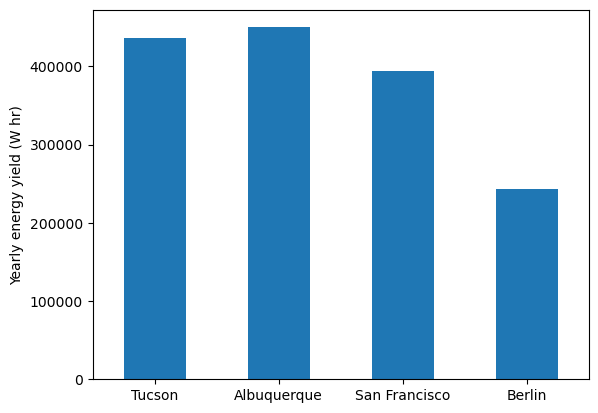

In [3]:
system = {'module': module, 'inverter': inverter,
          'surface_azimuth': 180}
energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    system['surface_tilt'] = latitude
    solpos = pvlib.solarposition.get_solarposition(
        time=weather.index,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        temperature=weather["temp_air"],
        pressure=pvlib.atmosphere.alt2pres(altitude),
    )
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    aoi = pvlib.irradiance.aoi(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos["apparent_zenith"],
        solpos["azimuth"],
    )

    total_irradiance = pvlib.irradiance.get_total_irradiance(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos['apparent_zenith'],
        solpos['azimuth'],
        weather['dni'],
        weather['ghi'],
        weather['dhi'],
        dni_extra=dni_extra,
        model='haydavies',
    )

    cell_temperature = pvlib.temperature.sapm_cell(
        total_irradiance['poa_global'],
        weather["temp_air"],
        weather["wind_speed"],
        **temperature_model_parameters,
    )

    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
        total_irradiance['poa_direct'],
        total_irradiance['poa_diffuse'],
        am_abs,
        aoi,
        module,
    )
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    annual_energy = ac.sum()
    energies[name] = annual_energy

energies = pd.Series(energies)
# based on the parameters specified above, these are in W*hrs
print(energies)
energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')


Tucson           435945.540454
Albuquerque      449905.103839
San Francisco    393749.728807
Berlin           243230.970659
dtype: float64


Text(0, 0.5, 'Yearly energy yield (W hr)')

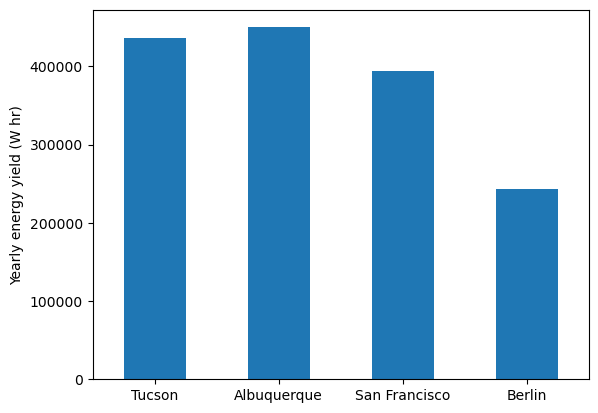

In [4]:
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain

energies = {}
for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    location = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
    )
    mount = FixedMount(surface_tilt=latitude, surface_azimuth=180)
    array = Array(
        mount=mount,
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
    )
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    mc = ModelChain(system, location)
    mc.run_model(weather)
    annual_energy = mc.results.ac.sum()
    energies[name] = annual_energy


energies = pd.Series(energies)
# based on the parameters specified above, these are in W*hrs
print(energies)
energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')


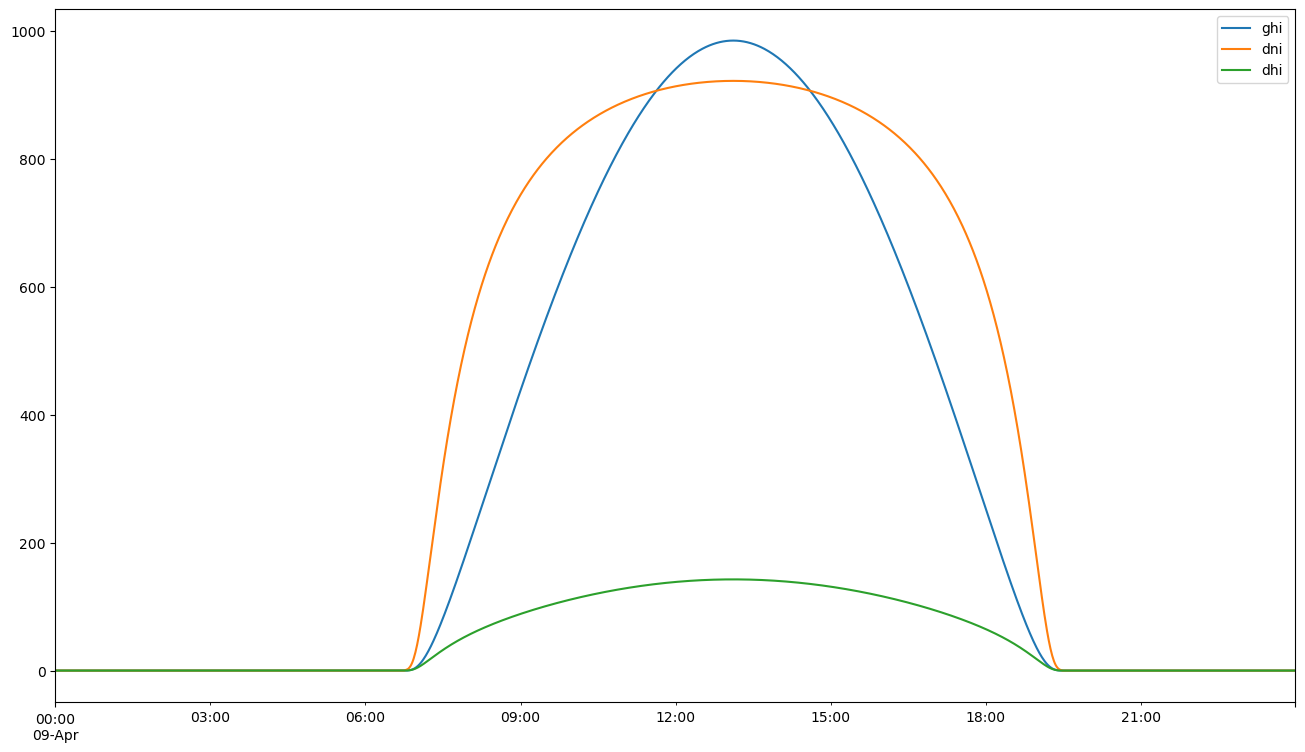

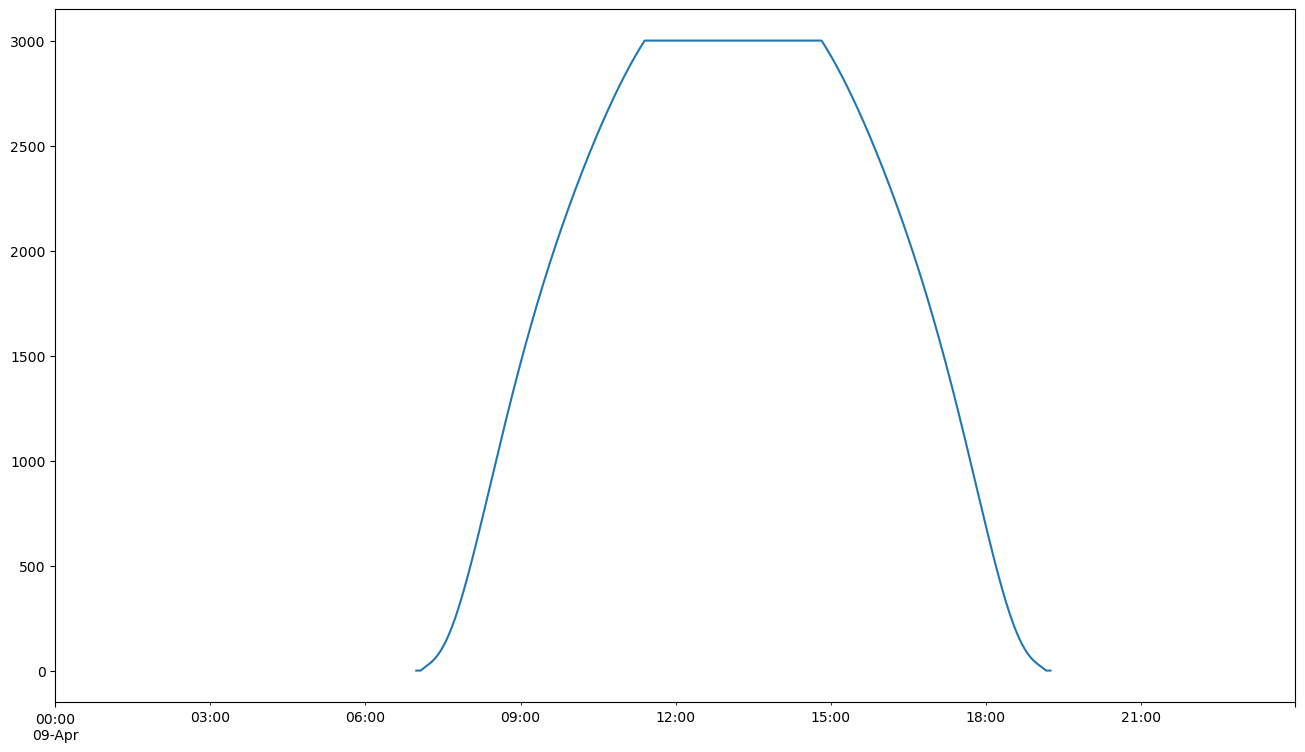

In [2]:
#Site information
#meters
altitude=1100
#coordinates
CAMS49 = [31.6676,-106.288]
tz='America/Boise'

import pvlib
from pvlib.modelchain import ModelChain
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import pandas as pd
import matplotlib.pyplot as plt

location = Location(latitude=CAMS49[0], longitude=CAMS49[1], tz=tz, altitude=altitude, name='CAMS49')
sandia_modules=pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters=pvlib.pvsystem.retrieve_sam('CECInverter')
module=sandia_modules['Canadian_Solar_CS6X_300M__2013_']
inverter=cec_inverters['ABB__PVI_3_0_OUTD_S_US__208V_']
temperature_parameters=TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

system= PVSystem(surface_tilt=45, surface_azimuth=180,
                 module_parameters=module,
                 inverter_parameters=inverter,
                 temperature_model_parameters=temperature_parameters,
                modules_per_string=7, strings_per_inverter=2)

modelchain = ModelChain(system, location)

time_series= pd.date_range(start=f'2019-04-09', end=f'2019-04-10', freq='1min',tz=location.tz)[:-1]
    

clear_sky=location.get_clearsky(time_series)

clear_sky.plot(figsize=(16,9))
plt.show()

modelchain.run_model(clear_sky)
modelchain.results.ac.plot(figsize=(16,9))
plt.show()


In [10]:
import os
file_path_pvlib=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\pvlib"

global_2019=pd.read_csv(os.path.join(file_path_pvlib,'Timeseries_31.668_-106.288_E5_0kWp_crystSi_14_v54deg_2019_2020.csv'), skiprows=8, nrows=8760, index_col=0)
global_2019

ParserError: Error tokenizing data. C error: Expected 1 fields in line 11, saw 9


'C:\\Users\\Zelda64\\Documents\\Programming\\dust_solar_power\\pvlib\\Timeseries_31.668_-106.288_E5_0kWp_crystSi_14_v54deg_2019_2020.csv'